# 0.データ読み込み

全解析で共通のデータフレームをここで読み込む。  
このDFを基本とし各解析ごとに不要な列の削除やdropを行うが、そのDropは次の解析には持ち越さず。毎回やり直す。

異常値の処理についても、上記の対応に同じ。各解析の中で異常値の行を落としても、他の解析で同行の異なる列のデータを利用する場合もあるので、全体には影響させないようにする。

In [312]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression



In [313]:
gpd_data = gpd.read_file('/workspaces/akita_daizu/data/474+120圃場.geojson')

In [338]:
soil_data = pd.read_excel('/workspaces/akita_daizu/data/0124修正_土壌データ+収量.xlsx', header=0)

UniquIDがふってある120圃場の解析だけで良いので、読み込んだ2ファイルを120圃場ののIDをKeyに接続する

In [339]:
# gpdの結合用うの行の削除と作成
gpd_data['作付け開始年'] = ''
gpd_data['圃場番号'] = gpd_data['uniqueID']
gpd_data['排水性の良否'] = gpd_data['pred_labels']
# gpdの必要な行だけ抽出して結合する ほしい行は以下の4行
selected_gpd = gpd_data[['圃場番号','排水性の良否','作付年_y', 'H23以前_y','播種月日','作付け開始年']]


In [340]:
#　この作付け年とH23以前をくっつけたい。　まず作付け年がからならH23以前を入れ込むようにFor
for index, row in selected_gpd[['作付年_y', 'H23以前_y','作付け開始年']].iterrows():
    if row['H23以前_y'] is not None :
        selected_gpd['作付け開始年'][index] =row['H23以前_y']
    elif  row['作付年_y'] is not None :
        selected_gpd['作付け開始年'][index] = row['作付年_y']

# それぞれの和暦を西暦に変更
# H23 2011 H24 2012 H25 2013 R1 2019
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ3～',r'2021',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ2～',r'2020',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ1～',r'2019',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ30～',r'2017',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ28～',r'2016',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ27～',r'2015',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ26～',r'2014',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ25～',r'2013',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ24～',r'2012',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'☑',r'2011',)
selected_gpd['作付け開始年'].unique()

/tmp/ipykernel_403/882395466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] =row['H23以前_y']
/tmp/ipykernel_403/882395466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] = row['作付年_y']
/tmp/ipykernel_403/882395466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'] = selected_gpd['作付け開始年']

array(['2011', '2019', '2013', '2012', '', '2020', '2015', '2016', '2014',
       '2017', '2021'], dtype=object)

In [341]:
target_selected_gpd =  selected_gpd[['圃場番号','排水性の良否', '播種月日','作付け開始年']]

In [342]:
#まず　GPDとSOILデータでuniqueIDをキーにして全部結合する
merged_pd = pd.merge(soil_data, target_selected_gpd, on=['圃場番号'], how='inner')

In [343]:
# heatmap作成のため不要な行の削除 土壌硬度周り
drop_columns = merged_pd.filter(like='土壌硬度', axis=1).columns.values
droped_soil_data = merged_pd.drop(drop_columns, axis = 1)

In [344]:
droped_soil_data.columns

Index(['圃場番号', '現場測定_EC (㎳／㎝)', '現場測定_PH', '生育状況', '最大圧の深さの平均', '最大圧力の平均',
       '播種月日_x', 'SoilName', '調査日', '現物重量ｋｇ', '計量時水分％', '圃場面積', '住所',
       '反収現物重量kg/10a', '15%時の重量', '15%反収現物重量kg/10a', '実験室測定_EC (㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)',
       'TN (%)', '排水性の良否', '播種月日_y', '作付け開始年'],
      dtype='object')

In [345]:
droped_soil_data

,圃場番号,現場測定_EC (㎳／㎝),現場測定_PH,生育状況,最大圧の深さの平均,最大圧力の平均,播種月日_x,SoilName,調査日,現物重量ｋｇ,...,アンモニア態窒素 (mg N/100g),硝酸態窒素 (mg N/100g),可給隊窒素 (mg N/100g),有効態リン酸 (mg P2O5/100g),TC (%),腐食 (%),TN (%),排水性の良否,播種月日_y,作付け開始年
0,1.0,27.67,7.36,NaN,23,4345,2021-07-04,典型普通砂質未熟土,12月 7日,723.0,...,1.53,0.62,4.40,37.0,1.00,1.72,0.106,1.0,2021-07-04,2011
1,2.0,31.00,6.42,NaN,21,2684,NaT,典型普通砂質未熟土,NaN,NaN,...,1.55,1.36,2.30,22.0,0.27,0.46,0.033,5.0,2021-07-04,2011
2,3.0,27.00,6.30,NaN,21,2684,NaT,典型普通砂質未熟土,NaN,NaN,...,1.58,0.13,3.85,15.9,0.36,0.62,0.040,1.0,2021-07-04,2011
3,4.0,17.33,6.49,NaN,17,2684,NaT,典型普通砂質未熟土,NaN,NaN,...,1.22,0.11,4.43,31.0,0.46,0.79,0.047,3.0,2021-07-04,2011
4,5.0,58.00,6.69,NaN,13,2684,2021-07-04,典型普通砂質未熟土,12月 7日,811.0,...,1.20,0.32,4.76,80.7,0.82,1.41,0.085,3.0,2021-07-04,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,117.0,34.00,5.83,NaN,28,2561,NaT,淡色普通非アロフェン質黒ボク土,NaN,NaN,...,2.27,0.46,8.55,79.0,4.34,7.46,0.329,3.0,2021-06-27,2011
108,118.0,27.67,5.46,NaN,26,2448,NaT,淡色普通非アロフェン質黒ボク土,NaN,NaN,...,1.86,1.22,2.98,36.6,4.12,7.09,0.295,2.0,2021-06-27,2011
109,119.0,44.00,5.70,NaN,18,2462,NaT,淡色普通非アロフェン質黒ボク土,NaN,NaN,...,1.79,0.39,7.03,120.5,3.89,6.69,0.279,1.0,2021-06-27,2011
110,120.0,55.00,6.06,NaN,39,2617,NaT,淡色普通非アロフェン質黒ボク土,NaN,NaN,...,1.76,0.59,8.27,103.4,3.20,5.50,0.241,2.0,2021-06-27,2011


In [346]:
# heatmap作成のため不要な行の削除
drop_columns = ['播種月日_x','生育状況','最大圧の深さの平均', '最大圧力の平均','調査日', '現物重量ｋｇ', '計量時水分％', '圃場面積', '住所', '反収現物重量kg/10a',
       '15%時の重量',]
second_droped_soil_data = droped_soil_data.drop(drop_columns, axis = 1)

In [347]:
second_droped_soil_data.columns

Index(['圃場番号', '現場測定_EC (㎳／㎝)', '現場測定_PH', 'SoilName', '15%反収現物重量kg/10a',
       '実験室測定_EC (㎳／㎝)', '実験室測定_pH', 'アンモニア態窒素 (mg N/100g)',
       '硝酸態窒素 (mg N/100g)', '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)',
       'TC (%)', '腐食 (%)', 'TN (%)', '排水性の良否', '播種月日_y', '作付け開始年'],
      dtype='object')

In [348]:
second_droped_soil_data

,圃場番号,現場測定_EC (㎳／㎝),現場測定_PH,SoilName,15%反収現物重量kg/10a,実験室測定_EC (㎳／㎝),実験室測定_pH,アンモニア態窒素 (mg N/100g),硝酸態窒素 (mg N/100g),可給隊窒素 (mg N/100g),有効態リン酸 (mg P2O5/100g),TC (%),腐食 (%),TN (%),排水性の良否,播種月日_y,作付け開始年
0,1.0,27.67,7.36,典型普通砂質未熟土,130.0,41.2,7.26,1.53,0.62,4.40,37.0,1.00,1.72,0.106,1.0,2021-07-04,2011
1,2.0,31.00,6.42,典型普通砂質未熟土,NaN,35.4,6.42,1.55,1.36,2.30,22.0,0.27,0.46,0.033,5.0,2021-07-04,2011
2,3.0,27.00,6.30,典型普通砂質未熟土,NaN,29.2,6.56,1.58,0.13,3.85,15.9,0.36,0.62,0.040,1.0,2021-07-04,2011
3,4.0,17.33,6.49,典型普通砂質未熟土,NaN,24.5,6.87,1.22,0.11,4.43,31.0,0.46,0.79,0.047,3.0,2021-07-04,2011
4,5.0,58.00,6.69,典型普通砂質未熟土,138.0,41.8,7.03,1.20,0.32,4.76,80.7,0.82,1.41,0.085,3.0,2021-07-04,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,117.0,34.00,5.83,淡色普通非アロフェン質黒ボク土,NaN,46.9,6.04,2.27,0.46,8.55,79.0,4.34,7.46,0.329,3.0,2021-06-27,2011
108,118.0,27.67,5.46,淡色普通非アロフェン質黒ボク土,NaN,49.9,5.50,1.86,1.22,2.98,36.6,4.12,7.09,0.295,2.0,2021-06-27,2011
109,119.0,44.00,5.70,淡色普通非アロフェン質黒ボク土,NaN,47.9,6.09,1.79,0.39,7.03,120.5,3.89,6.69,0.279,1.0,2021-06-27,2011
110,120.0,55.00,6.06,淡色普通非アロフェン質黒ボク土,NaN,48.3,6.30,1.76,0.59,8.27,103.4,3.20,5.50,0.241,2.0,2021-06-27,2011


In [349]:

# 作付け開始年はこれでint化　播種日はエクセルで日付けにしとく
second_droped_soil_data['作付け開始年'] = second_droped_soil_data['作付け開始年'].map(lambda x: int(x))
second_droped_soil_data['播種月日_y'].unique()


array(['2021-07-04', '2021-06-30', '2021-07-07', '2021-07-01',
       '2021-07-09', '2021-06-29', '2021-06-26', '2021-06-27'],
      dtype=object)

In [350]:
second_droped_soil_data['播種月日_y'] = pd.to_datetime(second_droped_soil_data['播種月日_y'])

In [351]:
# 播種日datatime形式だとheatmap作成時に読み込まれない？ intにする
int_time = second_droped_soil_data['播種月日_y'].map(pd.Timestamp.timestamp).astype(int)
# これに変換するともとのDatetimeに戻せない

In [352]:
int_time = second_droped_soil_data['播種月日_y'].dt.strftime('%m%d')
int2_time = int_time.str.lstrip('0').astype(int)

In [387]:
second_droped_soil_data['播種月日'] = int2_time
second_droped_soil_data = second_droped_soil_data.drop(['播種月日_y'], axis = 1)

In [388]:
# これで収量が入っている行には必ず作付け開始年も入力される
print(second_droped_soil_data.isnull().sum())

圃場番号                      0
現場測定_EC (㎳／㎝)             0
現場測定_PH                   0
SoilName                  0
15%反収現物重量kg/10a          81
実験室測定_EC (㎳／㎝)            0
実験室測定_pH                  0
アンモニア態窒素 (mg N/100g)      0
硝酸態窒素 (mg N/100g)         0
可給隊窒素 (mg N/100g)         0
有効態リン酸 (mg P2O5/100g)     0
TC (%)                    0
腐食 (%)                    0
TN (%)                    0
排水性の良否                    0
作付け開始年                    0
播種月日                      0
dtype: int64


In [401]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(second_droped_soil_data["SoilName"].values)

#データ変換
second_droped_soil_data["土壌_CD"] = LE.fit_transform(second_droped_soil_data["SoilName"].values)
print(second_droped_soil_data["土壌_CD"].unique())
print(second_droped_soil_data["SoilName"].unique())

[1 2 0]
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']


# 1.収量と各パラメータの相関分析

## 1-1 全体の相関について

In [409]:
# ex ph 共に異常値を取り除く
soil_data_wo_error = second_droped_soil_data.drop(second_droped_soil_data[second_droped_soil_data['実験室測定_pH']>1000].index)
soil_data_wo_error = soil_data_wo_error.drop(soil_data_wo_error[soil_data_wo_error['現場測定_EC (㎳／㎝)']>100].index)

# 表示順序変える
# soil_data_wo_error.columns
soil_data_wo_error_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '現場測定_EC (㎳／㎝)', '現場測定_PH', '実験室測定_EC (㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)', 'TN (%)','作付け開始年', '土壌_CD']]

In [410]:
corr = soil_data_wo_error.corr()
corr

,圃場番号,現場測定_EC (㎳／㎝),現場測定_PH,15%反収現物重量kg/10a,実験室測定_EC (㎳／㎝),実験室測定_pH,アンモニア態窒素 (mg N/100g),硝酸態窒素 (mg N/100g),可給隊窒素 (mg N/100g),有効態リン酸 (mg P2O5/100g),TC (%),腐食 (%),TN (%),排水性の良否,作付け開始年,播種月日,Soil_Encoding,土壌_CD
圃場番号,1.000000,0.203450,-0.488124,0.066192,0.526036,-0.545804,-0.186572,0.129041,0.518512,0.253688,0.528293,0.528349,0.551093,-0.178013,0.005550,-0.629959,0.089387,0.089387
現場測定_EC (㎳／㎝),0.203450,1.000000,-0.219807,-0.098741,0.409527,-0.151020,0.122490,0.457364,0.335168,0.451480,0.172105,0.171980,0.274330,-0.008765,0.013548,-0.488174,0.118933,0.118933
現場測定_PH,-0.488124,-0.219807,1.000000,0.382815,-0.497931,0.896704,-0.020647,-0.300745,-0.476238,-0.117826,-0.616072,-0.615975,-0.651234,0.065941,-0.208774,0.463601,-0.319881,-0.319881
15%反収現物重量kg/10a,0.066192,-0.098741,0.382815,1.000000,0.079567,0.272177,0.110913,0.085855,-0.267269,0.025712,-0.346953,-0.346927,-0.351237,-0.193980,-0.338823,-0.402371,-0.325983,-0.325983
実験室測定_EC (㎳／㎝),0.526036,0.409527,-0.497931,0.079567,1.000000,-0.612964,0.119004,0.515081,0.374244,0.285729,0.561639,0.561741,0.637582,-0.005864,-0.058266,-0.609568,0.198096,0.198096
実験室測定_pH,-0.545804,-0.151020,0.896704,0.272177,-0.612964,1.000000,-0.046654,-0.339861,-0.455404,-0.087322,-0.662753,-0.662642,-0.696320,0.123206,-0.128364,0.508287,-0.377435,-0.377435
アンモニア態窒素 (mg N/100g),-0.186572,0.122490,-0.020647,0.110913,0.119004,-0.046654,1.000000,0.254163,-0.187168,0.054727,0.018648,0.018703,0.069902,0.184973,-0.070496,-0.150392,0.139360,0.139360
硝酸態窒素 (mg N/100g),0.129041,0.457364,-0.300745,0.085855,0.515081,-0.339861,0.254163,1.000000,0.014316,0.346553,0.439492,0.439353,0.506444,0.100962,-0.024329,-0.433948,0.209122,0.209122
可給隊窒素 (mg N/100g),0.518512,0.335168,-0.476238,-0.267269,0.374244,-0.455404,-0.187168,0.014316,1.000000,0.217548,0.375636,0.375476,0.409164,-0.158581,0.280030,-0.358433,0.137091,0.137091
有効態リン酸 (mg P2O5/100g),0.253688,0.451480,-0.117826,0.025712,0.285729,-0.087322,0.054727,0.346553,0.217548,1.000000,0.341629,0.341892,0.360348,0.041627,-0.037863,-0.330655,0.095111,0.095111


<AxesSubplot:>

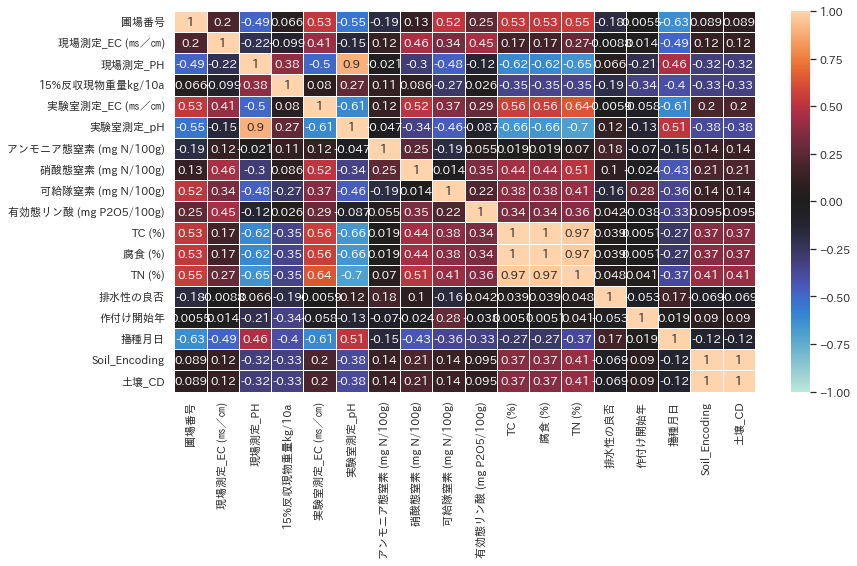

In [406]:
# sns　setするとフォントもデフォルトのsans serifになって文字化けするから、Plotサイズ変える時にフォントも指定する
sns.set(rc = {'figure.figsize':(13,7)},font='IPAexGothic')
sns.heatmap(corr,annot=True, vmax=1, vmin=-1, center=0,linewidths=.5)

## 1-2詳細分析

In [420]:
# 相関を確認するデータをグループ分けして　個別のパラメータとランダム効果の比較
# 1.一番大きな括り　土壌をランダム効果として各パラメータの相関を見る
data_random_soil_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '実験室測定_EC (㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)', 'TN (%)', '土壌_CD']]

# 2.一番大きな括り　排水性指標
data_random_vwc_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '実験室測定_EC (㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)', 'TN (%)', '排水性の良否']]


土壌分類対応表
[1 2 0]  
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']

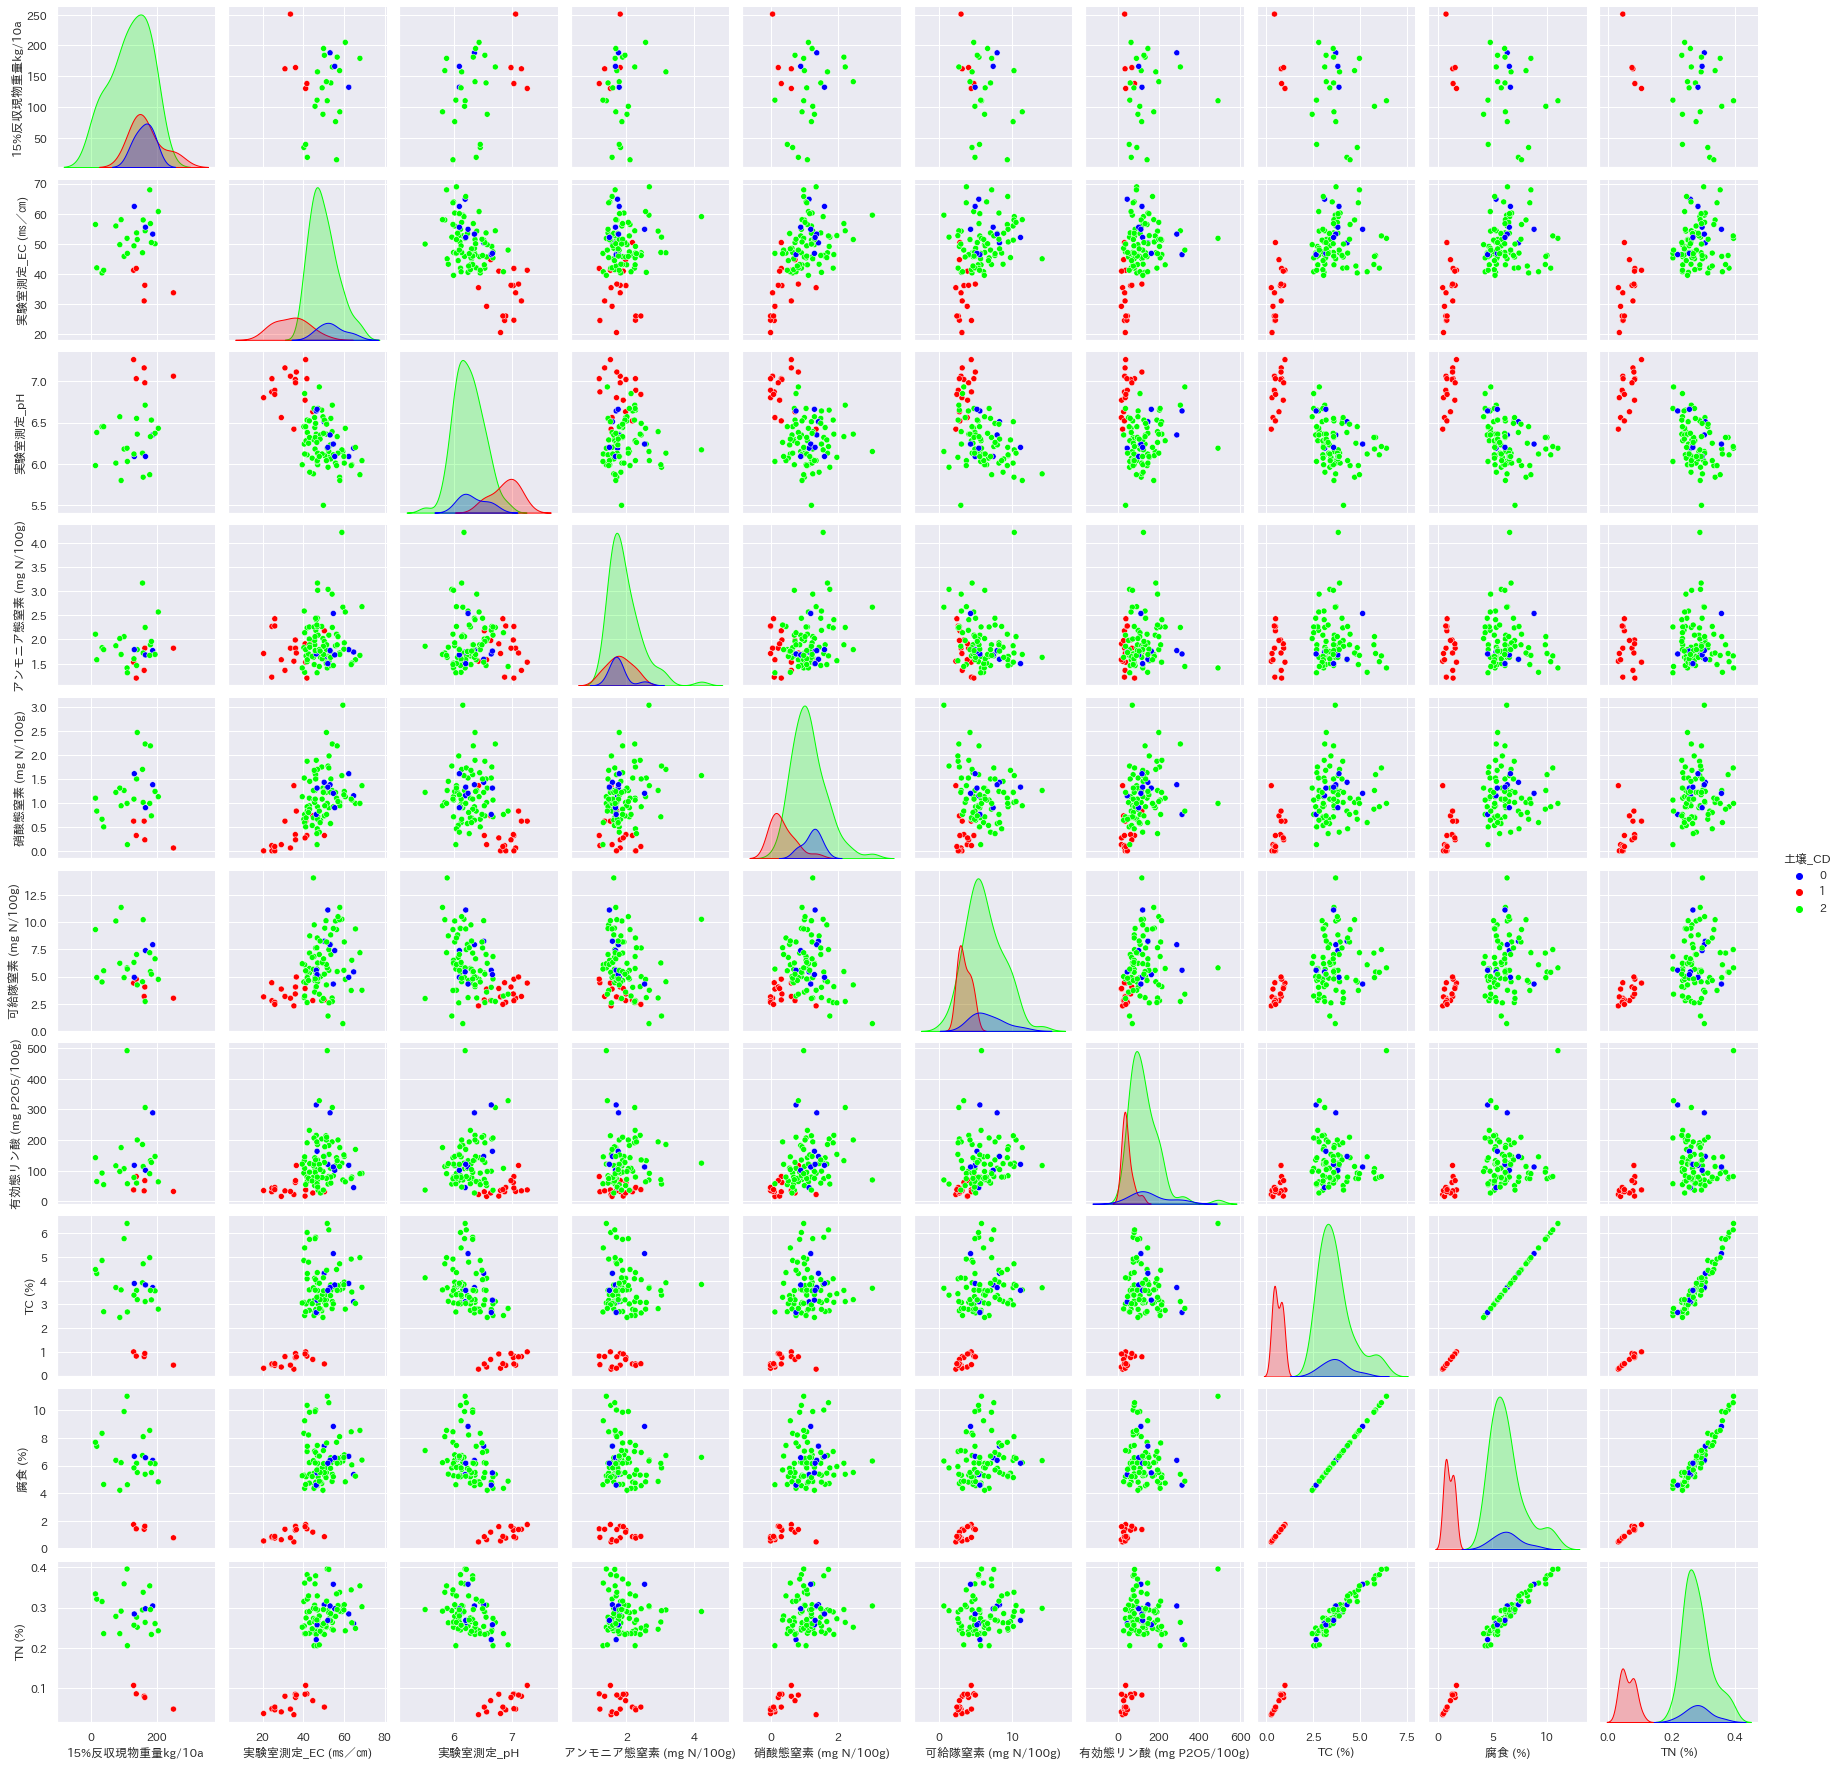

In [421]:
# 赤が'典型普通砂質未熟土'　緑が'淡色普通非アロフェン質黒ボク'　青が'グライ低地土'
sns.pairplot(data_random_soil_sort, hue="土壌_CD", palette={1: 'red',2: '#00ff00',0: 'blue'})

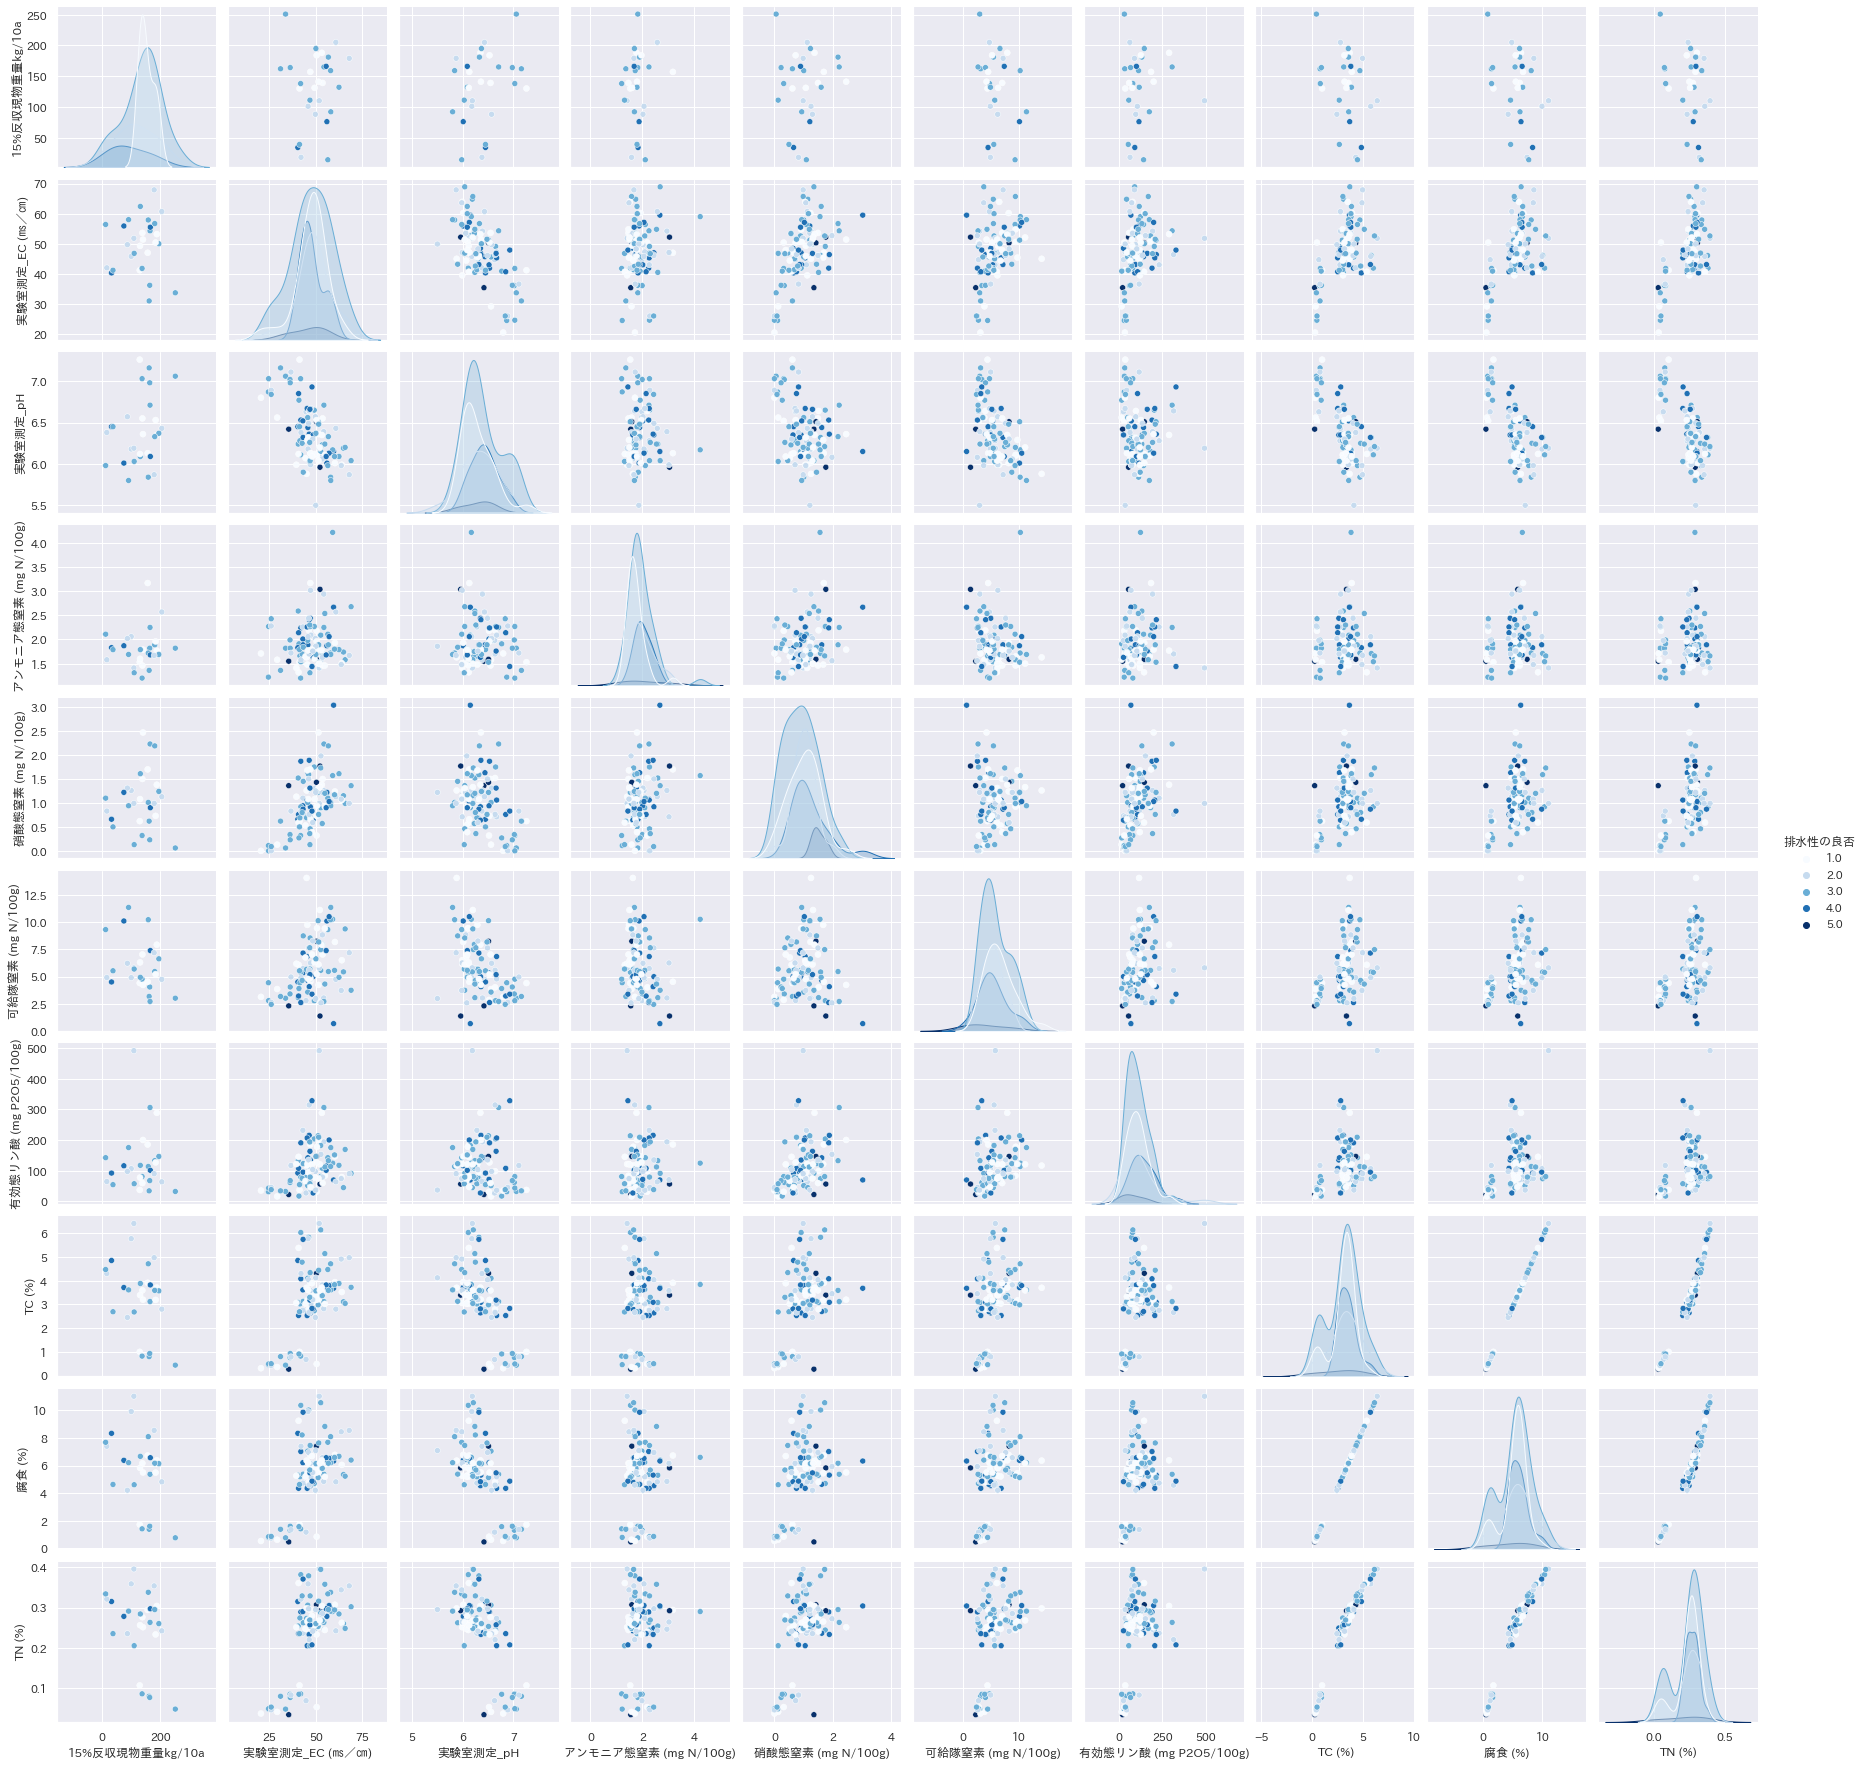

In [423]:
#　排水性での評価
sns.pairplot(data_random_vwc_sort, hue="排水性の良否", palette='Blues')

In [309]:
print(second_droped_soil_data.isnull().sum())

圃場番号                      0
現場測定_EC (㎳／㎝)             0
現場測定_PH                   0
SoilName                  0
15%反収現物重量kg/10a          81
実験室測定_EC (㎳／㎝)            0
実験室測定_pH                  0
アンモニア態窒素 (mg N/100g)      0
硝酸態窒素 (mg N/100g)         0
可給隊窒素 (mg N/100g)         0
有効態リン酸 (mg P2O5/100g)     0
TC (%)                    0
腐食 (%)                    0
TN (%)                    0
播種月日_y                    0
作付け開始年                    0
dtype: int64


In [424]:
soil_data_only_yield= second_droped_soil_data.dropna()

In [425]:
# 収量のないデータをドロップ
soil_data_only_yield.shape


(31, 19)

In [428]:
data_only_yield_soil_sort = soil_data_only_yield[['実験室測定_EC (㎳／㎝)','実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)', 'TN (%)', '土壌_CD','15%反収現物重量kg/10a']]
data_only_yield_vwc_sort = soil_data_only_yield[['実験室測定_EC (㎳／㎝)','実験室測定_pH', 'アンモニア態窒素 (mg N/100g)', '硝酸態窒素 (mg N/100g)',
       '可給隊窒素 (mg N/100g)', '有効態リン酸 (mg P2O5/100g)', 'TC (%)', '腐食 (%)', 'TN (%)', '排水性の良否','15%反収現物重量kg/10a']]

TypeError: lmplot() got an unexpected keyword argument 'ax'

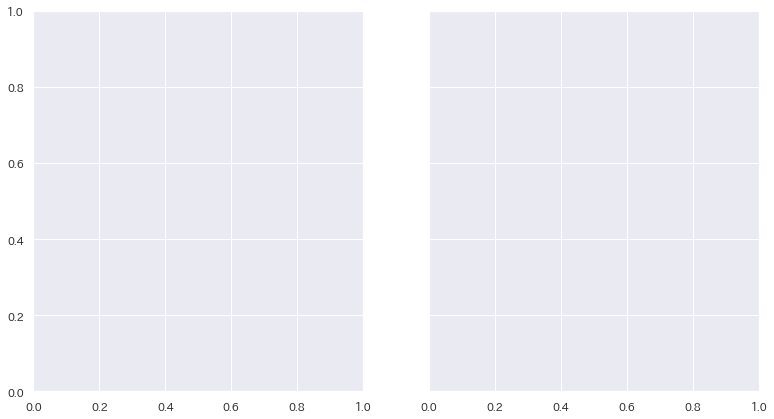

In [430]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.lmplot(x='実験室測定_EC (㎳／㎝)', y='15%反収現物重量kg/10a',hue = '土壌_CD',data = data_only_yield_soil_sort, ax=ax1)
sns.lmplot(x='実験室測定_pH', y='15%反収現物重量kg/10a',hue = '土壌_CD',data = data_only_yield_soil_sort, ax=ax2)


In [36]:
X = soil_data_only_yield.iloc[:,:-1]  # 全行対象,最終カラム以外をXとする
y = soil_data_only_yield.iloc[:,-1] # 全行対象,最終カラムをyとする

# 2.現場計測値と実験室計測値の相関分析

## 2-1簡易測定ph 実験室測定ph

Phは現場測定値と実験室の値が比較的近い

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


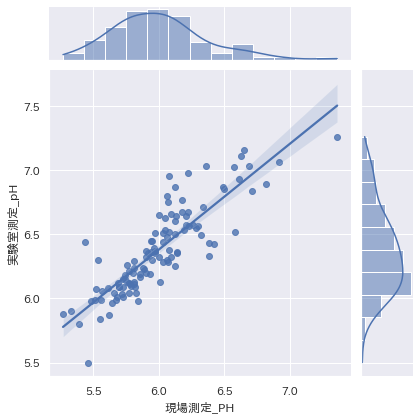

In [369]:
# 異常値取り除く
ph_soil = soil_data.drop(soil_data[soil_data['実験室測定_pH']>1000].index)
sns.jointplot(soil_data['現場測定_PH'], soil_data['実験室測定_pH'], kind="reg")

In [ ]:
x = ph_soil[['現場測定_PH']]
y = ph_soil[['実験室測定_pH']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.826x + 1.423
決定係数 R^2：  0.744282650456441


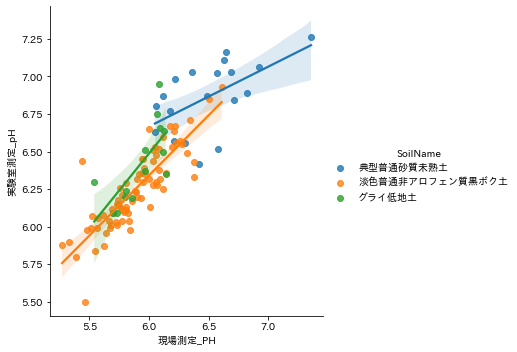

In [ ]:
sns.lmplot(x='現場測定_PH',y='実験室測定_pH',hue = 'SoilName',data = ph_soil)

## 2-2 簡易測定EC 実験室測定EC

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


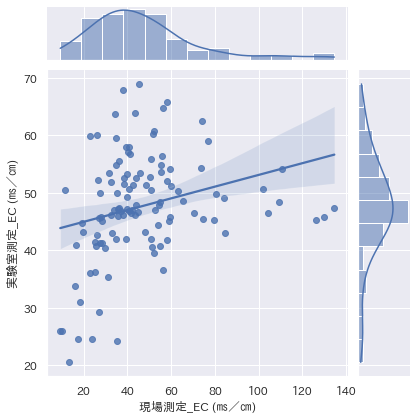

In [371]:
sns.jointplot(soil_data['現場測定_EC (㎳／㎝)'], soil_data['実験室測定_EC (㎳／㎝)'], kind="reg")

In [ ]:
x = ph_soil[['現場測定_EC']]
y = ph_soil[['実験室測定_EC (㎳／㎝)']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.103x + 42.825
決定係数 R^2：  0.07274036083856361


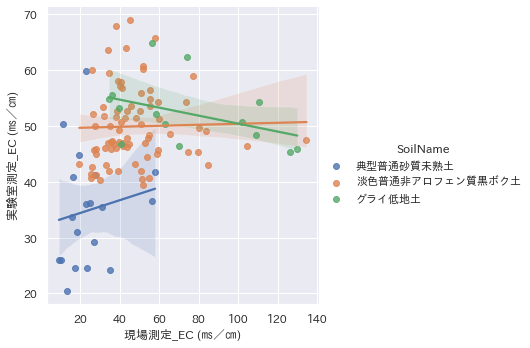

In [373]:
sns.lmplot(x='現場測定_EC (㎳／㎝)',y='実験室測定_EC (㎳／㎝)',hue = 'SoilName',data = soil_data)

ECは現場計測で値が100以上のものを外れ値として外せないか？ 箱書いて検討

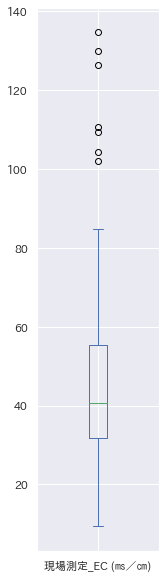

In [374]:
from date_analysis import get_box
get_box(soil_data ,['現場測定_EC (㎳／㎝)'] )
# df 表示しないようにしたい

In [375]:
from date_analysis import box_Outlier
box_Outlier(soil_data ,['現場測定_EC (㎳／㎝)'] )

現場測定_EC (㎳／㎝)
Q1は：31.67
Q3は：55.33
IQRは：23.659999999999997
外れ値は↓
60     134.67
71     110.67
72     130.00
73     109.33
74     102.00
82     104.33
101    126.33
Name: 現場測定_EC (㎳／㎝), dtype: float64
*********************


In [379]:
# 上記の結果より100以上を外れ値として処理すると
ec_soil = soil_data.drop(soil_data[soil_data['現場測定_EC (㎳／㎝)']>100].index)

In [380]:
x = ec_soil[['現場測定_EC (㎳／㎝)']]
y = ec_soil[['実験室測定_EC (㎳／㎝)']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.224x + 38.180
決定係数 R^2：  0.1540733052793254


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


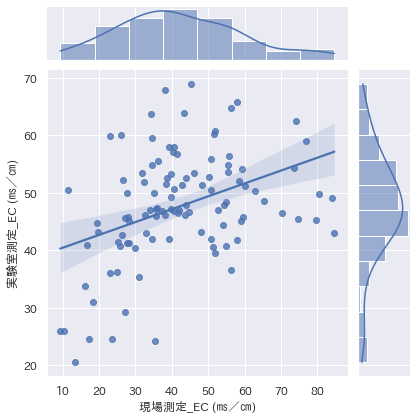

In [381]:
sns.jointplot(ec_soil['現場測定_EC (㎳／㎝)'], ec_soil['実験室測定_EC (㎳／㎝)'], kind="reg")

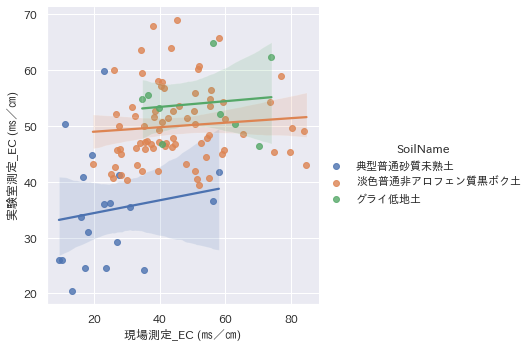

In [383]:
sns.lmplot(x='現場測定_EC (㎳／㎝)',y='実験室測定_EC (㎳／㎝)',hue = 'SoilName',data = ec_soil )

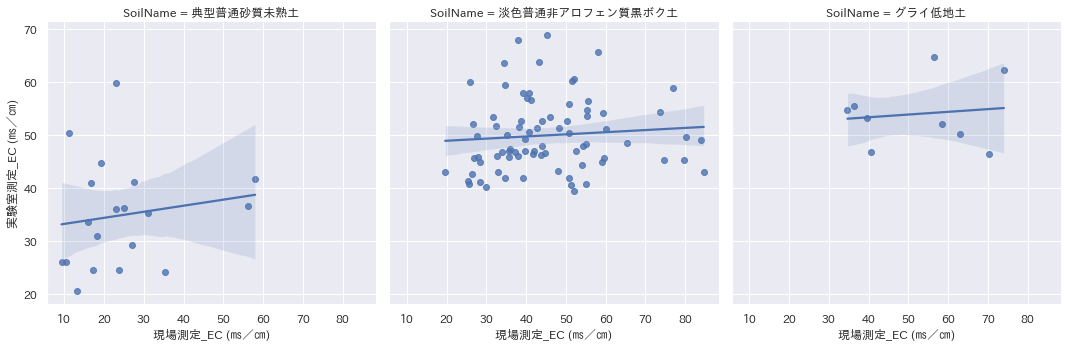

In [384]:
sns.lmplot(x='現場測定_EC (㎳／㎝)',y='実験室測定_EC (㎳／㎝)',col = 'SoilName',data = ec_soil )


## 2-3 現場測定値から可給態窒素の推定

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


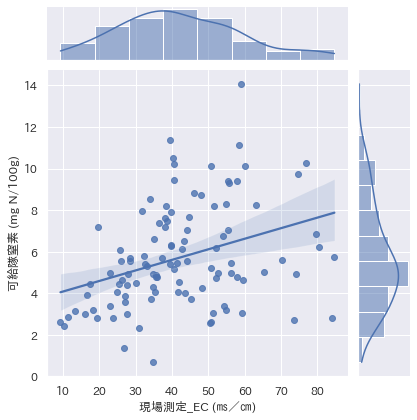

In [385]:
sns.jointplot(ec_soil['現場測定_EC (㎳／㎝)'], ec_soil['可給隊窒素 (mg N/100g)'], kind="reg")

In [386]:
x = ec_soil[['現場測定_EC (㎳／㎝)']]
y = ec_soil[['可給隊窒素 (mg N/100g)']]
model_lr = LinearRegression()
model_lr.fit(x, y)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

y= 0.051x + 3.567
決定係数 R^2：  0.11924567043992562
